Gram altın fiyatlarını tahmin ettiğim projede makine öğrenmesi ve zaman serisi yöntemlerini kullanarak, Linear Regression, Random Forest ve ARIMA modellerinin performanslarını karşılaştırdım.

1. Gerekli Kütüphanelerin Kurulumu

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from google.colab import files
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm

In [3]:
!pip install --upgrade --force-reinstall numpy==1.24.4 pmdarima

  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached cython-3.1.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.9 kB)
  Using cached pandas-2.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached scikit_learn-1.7.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached scipy-1.16.0-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (61 kB)
  Using cached statsmodels-0.14.5-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (9.5 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached 

2. Veriyi Okuma
- Veri (GAU/TRY - Gram Altın Türk Lirası): Türkiye’de gram altın (GAU/TRY) fiyatlarını analiz ettiğim projemde veri kaynağı olarak güncel fiyat takibi sunan Investing.com’un GAU/TRY sayfasını kullandım. https://tr.investing.com/currencies/gau-try-historical-data

In [13]:
uploaded = files.upload()


Saving GAU_TRY Geçmiş Verileri (2).csv to GAU_TRY Geçmiş Verileri (2).csv


In [14]:
df = pd.read_csv('GAU_TRY Geçmiş Verileri (2).csv')
df.head()

,Tarih,Şimdi,Açılış,Yüksek,Düşük,Hac.,Fark %
0,18.07.2025,"4.352,395","4.334,178","4.363,760","4.325,258",NaN,"0,42%"
1,17.07.2025,"4.334,138","4.330,901","4.338,241","4.286,940",NaN,"0,07%"
2,16.07.2025,"4.330,901","4.311,295","4.369,778","4.296,750",NaN,"0,46%"
3,15.07.2025,"4.311,255","4.326,918","4.353,054","4.294,073",NaN,"-0,36%"
4,14.07.2025,"4.326,701","4.355,154","4.363,330","4.313,531",NaN,"-0,66%"


In [15]:
df.shape


(3674, 7)

3. Veri Ön İşleme: Hacim, fark sütunları kaldırıldı. Tarih dönüştürme işlemş yapıldı. Fiyat verileri sayısal formata çevrildi.  

In [16]:
df = df.drop(columns=['Hac.', 'Fark %'])
df.head()


,Tarih,Şimdi,Açılış,Yüksek,Düşük
0,18.07.2025,"4.352,395","4.334,178","4.363,760","4.325,258"
1,17.07.2025,"4.334,138","4.330,901","4.338,241","4.286,940"
2,16.07.2025,"4.330,901","4.311,295","4.369,778","4.296,750"
3,15.07.2025,"4.311,255","4.326,918","4.353,054","4.294,073"
4,14.07.2025,"4.326,701","4.355,154","4.363,330","4.313,531"


In [17]:
df['Tarih'] = pd.to_datetime(df['Tarih'], format="%d.%m.%Y")
price_columns = ['Şimdi', 'Açılış', 'Yüksek', 'Düşük']

for col in price_columns:
    df[col] = df[col].str.replace('.', '', regex=False)
    df[col] = df[col].str.replace(',', '.', regex=False).astype(float)

df = df.sort_values('Tarih').reset_index(drop=True)

In [18]:
df = df.rename(columns={'Tarih': 'Date', 'Şimdi': 'Current_Price', 'Açılış': 'Open_Price', 'Yüksek': 'High_Price', 'Düşük': 'Low_Price'})


In [19]:
print("En erken tarih:", df['Date'].min())
print("En geç tarih:", df['Date'].max())


En erken tarih: 2013-04-11 00:00:00
En geç tarih: 2025-07-18 00:00:00


In [20]:
df.head()

,Date,Current_Price,Open_Price,High_Price,Low_Price
0,2013-04-11,89.495,89.632,90.068,89.238
1,2013-04-12,85.236,89.523,89.835,85.102
2,2013-04-15,77.753,85.161,86.025,76.960
3,2013-04-16,78.620,77.945,80.776,76.185
4,2013-04-17,79.634,78.718,80.487,78.418


In [ ]:
df.dtypes

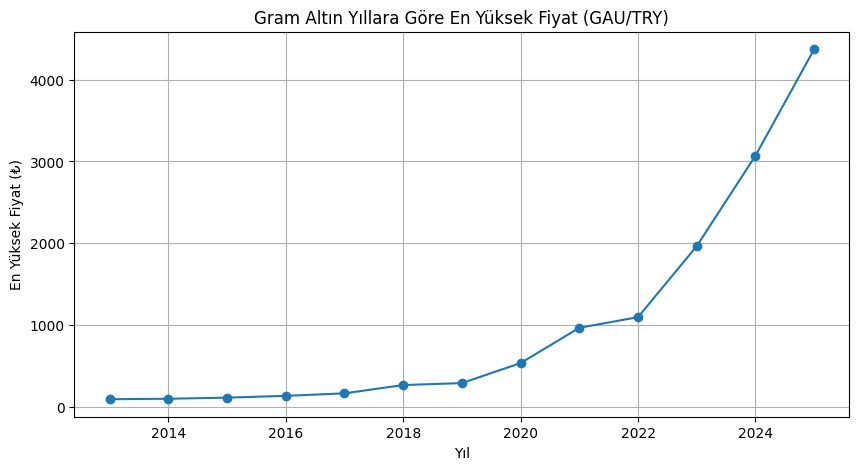

In [21]:
df['Yıl'] = df['Date'].dt.year

# Yıllara göre en yüksek fiyatı hesaplayalım
yillik_en_yuksek = df.groupby('Yıl')['Current_Price'].max()

plt.figure(figsize=(10, 5))
plt.plot(yillik_en_yuksek.index, yillik_en_yuksek.values, marker='o', linestyle='-')
plt.xlabel('Yıl')
plt.ylabel('En Yüksek Fiyat (₺)')
plt.title('Gram Altın Yıllara Göre En Yüksek Fiyat (GAU/TRY)')
plt.grid(True)
plt.show()

4.1 Linear Regression Model için X ve y Hazırlama

In [22]:
df['Tomorrow'] = df['Current_Price'].shift(-1)
df = df[df['Tomorrow'].notna()]

X = df[['Current_Price']]
y = df['Tomorrow']  # Ertesi günün fiyatı

print("DataFrame hazırlığı tamamlandı. Son DataFrame'in ilk 5 satırı:")
print(df.head())

DataFrame hazırlığı tamamlandı. Son DataFrame'in ilk 5 satırı:
        Date  Current_Price  Open_Price  High_Price  Low_Price   Yıl  Tomorrow
0 2013-04-11         89.495      89.632      90.068     89.238  2013    85.236
1 2013-04-12         85.236      89.523      89.835     85.102  2013    77.753
2 2013-04-15         77.753      85.161      86.025     76.960  2013    78.620
3 2013-04-16         78.620      77.945      80.776     76.185  2013    79.634
4 2013-04-17         79.634      78.718      80.487     78.418  2013    80.240


4.1.2 Eğitim ve Test Verisi Bölme

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


4.1.3. Model Kurma ve Eğitme

In [24]:
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


4.1.4 Tahmin

In [25]:
y_pred = model.predict(X_test)


4.1.5 Model Performansını Ölçme


In [26]:
from sklearn.metrics import mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 18.07
RMSE: 27.73


4.1.6 Görselleştirme

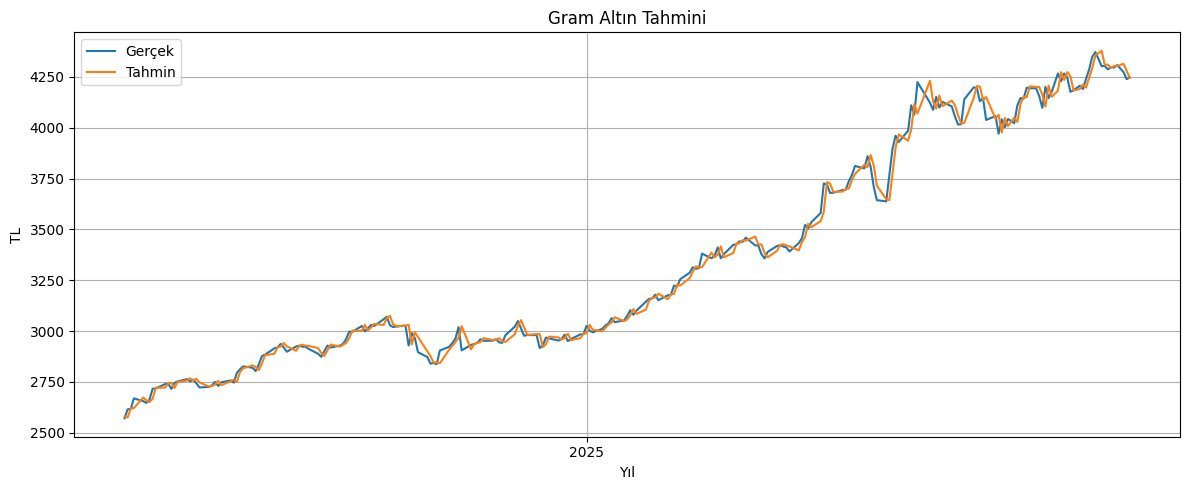

In [ ]:
plt.figure(figsize=(12, 5))

plt.plot(df.loc[y_test.index, 'Date'], y_test.values, label='Gerçek')
plt.plot(df.loc[y_test.index, 'Date'], y_pred, label='Tahmin')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # her yıl için bir işaret
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # sadece yılı yaz

plt.legend()
plt.title('Gram Altın Tahmini')
plt.xlabel('Yıl')
plt.ylabel('TL')
plt.grid()
plt.tight_layout()
plt.show()


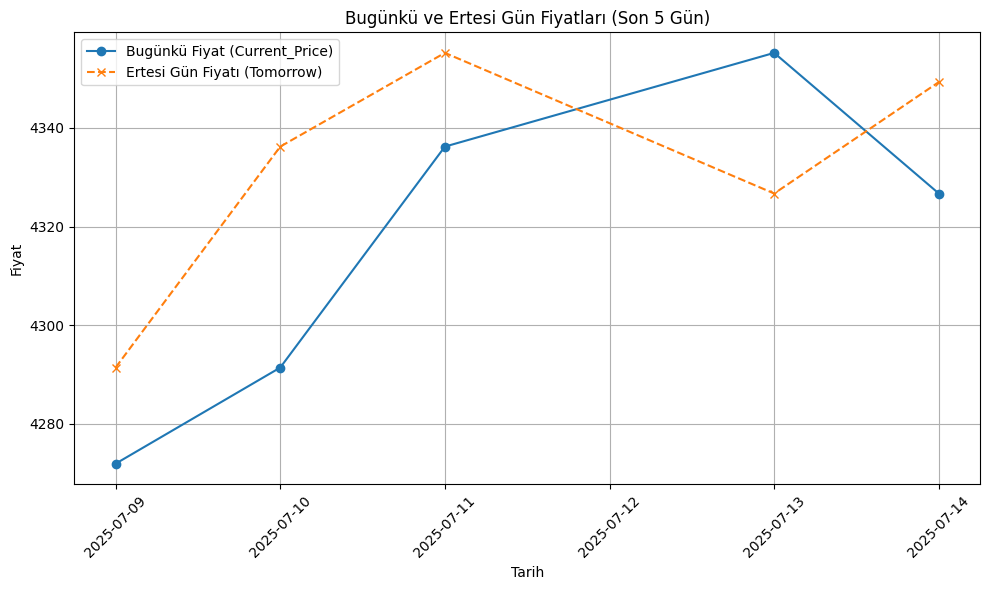

In [ ]:
df_last_week = df.tail(5)

plt.figure(figsize=(10, 6))
plt.plot(df_last_week['Date'], df_last_week['Current_Price'], marker='o', label='Bugünkü Fiyat (Current_Price)')
plt.plot(df_last_week['Date'], df_last_week['Tomorrow'], marker='x', label='Ertesi Gün Fiyatı (Tomorrow)', linestyle='--')

plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.title('Bugünkü ve Ertesi Gün Fiyatları (Son 5 Gün)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

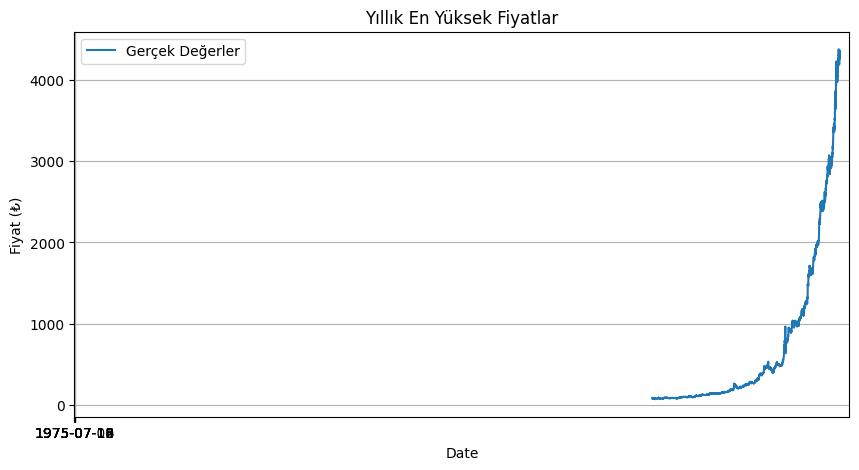

In [33]:
plt.figure(figsize=(10, 5))

plt.plot(df['Date'], df['Current_Price'], label='Gerçek Değerler')

plt.xlabel('Date')
plt.ylabel('Fiyat (₺)')
plt.title('Yıllık En Yüksek Fiyatlar')

plt.xticks([2014, 2016, 2018, 2020, 2022, 2024])

plt.grid(True)
plt.legend()
plt.show()


4.2 Random Forest

In [ ]:
model2 = RandomForestRegressor(n_estimators=100, random_state=42)
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)

In [ ]:
mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 807.29
RMSE: 1010.49


4.3 Time Series
- Bir zaman serisi, belirli bir kronolojik zaman sırasına göre bir dizi veya sayısal veri noktasıdır.
- Mevsimsel kalıpları, eğilimleri ve dış etkenlerle olan ilişkileri göstermek için çizgi grafikleri kullanır.
- Zaman serileri genelde durağan değildir. Bu seriler birinci veya ikinci farkları ya da logaritmaları alınarak durağan hale getirilmektedir.
- Zaman Serisi Bileşenleri:
 - Trend: Verilerin yukarı ya da aşağı yönlü olarak uzun vadede sergiledikleri harekete denir.
 - Mevsimsellik: Bir dönem boyunca tekrar eden belirli bir kalıbı tanımalar.  
 - Level (Düzey): Serinin düz bir çizgi olması durumunda taban değeri
 - Gürültü: Model tarafından açıklanamayan gözlemlerdeki değişkenlik

 *Y = levels + trends + seasonality + noise*

Durağanlık Kontrolü
- Durağanlık (Stationary): Serinin ortalama ve varyansın sabit kalması
- Bir zaman serisinin iyi modellenebilmesi için durağan özelliğe sahip olması gereklidir.
- Bir seri durağan değilse farklı örüntüler sergiler. Bu durumda serinin davranışı diğer dönemlere genellenemez,geleceği tahmin etmek için faydalı olmaz.
- Birim Kök Testleri
 - Genişletilmiş Dickey-Fuller Testi ADF:
  -Sıfır Hipotezi: Zaman serisinin durağan dışı (birim kök içerir)
  -Alternatif Hipotez: Zaman serisinin durağan
  -T-test üzerinden hesaplanan değer ADF Testi için hesaplanmış olan kritik değerlerden küçükse sıfır hipotezi reddedilir ve bu serinin durağan olduğu anlamına gelir. Eğer sıfır hipotezini reddetmekte başarısız olunursa seri birim kök içerir yani durağan-dışı deriz


In [ ]:
ts = df['Current_Price']

print("--- Durağanlık Kontrolü (ADF Testi) ---")
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    for key, value in result[4].items():
        print(f'Critical Values ({key}): {value:.4f}')
    if result[1] <= 0.05:
        print("Sonuç: Seri durağandır (null hipotezi reddedildi).")
    else:
        print("Sonuç: Seri durağan değildir (null hipotezi reddedilemedi). Fark alma gerekebilir.")

adf_test(ts)

--- Durağanlık Kontrolü (ADF Testi) ---
ADF Statistic: 3.9781
p-value: 1.0000
Critical Values (1%): -3.4348
Critical Values (5%): -2.8635
Critical Values (10%): -2.5678
Sonuç: Seri durağan değildir (null hipotezi reddedilemedi). Fark alma gerekebilir.


Fark Alma (Differencing): Değerin kendinden önceki değerden çıkartılması.
- Seriyi durağan hale getirmek için kullanılır. (d)

In [ ]:
#--- 2. Fark Alma (Gerekirse) ---
# Eğer ADF testi p-value > 0.05 ise fark alma işlemi uygularız.
# Altın fiyatları genellikle durağan değildir, bu yüzden bir kez fark almayı deneyeceğiz.
# pmdarima'nın auto_arima'sı d'yi otomatik bulacaktır.
ts_diff = ts.diff().dropna()
print("\n--- 1. Farkı Alınmış Serinin ADF Testi ---")
if len(ts_diff) > 0: # ts_diff boş değilse test yap
    adf_test(ts_diff)
else:
    print("Fark alınmış seri çok kısa veya boş, test yapılamadı.")


--- 1. Farkı Alınmış Serinin ADF Testi ---
ADF Statistic: -20.4662
p-value: 0.0000
Critical Values (1%): -3.4348
Critical Values (5%): -2.8635
Critical Values (10%): -2.5678
Sonuç: Seri durağandır (null hipotezi reddedildi).


# --- 3. Model Parametrelerini Belirleme (p, d, q) ---


In [ ]:
print("\n--- auto_arima ile Optimal ARIMA Parametrelerini Bulma ---")
# m=1 (mevsimsel değil), seasonal=False (mevsimsel bileşen yok), d=None
try:
    arima_model_auto = pm.auto_arima(ts,
                                     start_p=1, start_q=1,
                                     test='adf',       # d parametresi için durağanlık testi
                                     max_p=3, max_q=3,  # Maksimum p ve q değerleri
                                     d=None,           # d değerini otomatik belirle
                                     seasonal=False,   # Mevsimsel bileşen yok
                                     stepwise=True,
                                     trace=True,       # Hangi modellerin denendiğini göster
                                     suppress_warnings=True, # Uyarıları gizle
                                     error_action='ignore') # Hataları göz ardı et
    print(arima_model_auto.summary())
    optimal_order = arima_model_auto.order
    print(f"\nOptimal ARIMA Order (p, d, q): {optimal_order}")
except Exception as e:
    print(f"auto_arima çalışırken hata oluştu (veri seti çok kısa olabilir veya durağanlık sorunları): {e}")
    # Hata durumunda manuel bir başlangıç order'ı belirleyelim
    # Örneğin, p=1, d=1 (birinci fark), q=1
    optimal_order = (1, 1, 1)
    print(f"Varsayılan ARIMA Order olarak {optimal_order} kullanılıyor.")



--- auto_arima ile Optimal ARIMA Parametrelerini Bulma ---
Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13122.711, Time=2.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13119.748, Time=0.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13121.655, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13121.663, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13140.715, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 3.161 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1463
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6557.874
Date:                Wed, 16 Jul 2025   AIC                          13119.748
Time:                        20:33:12   BIC                          13130.323
Sample:                             0   HQIC                         13123.693
                               - 1463                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


X/y

In [ ]:
df['Tomorrow'] = df['Current_Price'].shift(-1)
df = df[df['Tomorrow'].notna()]

X = df[['Current_Price', 'Open_Price', 'High_Price', 'Low_Price']]
y = df['Tomorrow']

Test/Train

NEDEN X, y ayrımı yapmadık
- Tek Değişkenli Odak (Univariate): ARIMA modelleri genellikle tek bir zaman serisi üzerinde çalışır ve o serinin geçmiş değerlerini kullanarak gelecekteki değerlerini tahmin eder.

-Kendi Kendine Bağımlılık: ARIMA, serinin kendi içindeki geçmiş değerleri (otoregresif bileşen - AR) ve geçmiş tahmin hataları (hareketli ortalama bileşen - MA) arasındaki bağımlılıkları yakalar.

-Harici Özellik Kullanımı Yok (Varsayılan): Standart ARIMA modelleri, Open_Price veya High_Price gibi harici (exogenous) özellikler kullanmaz. Sadece tahmin etmeye çalıştığınız serinin geçmişine odaklanır.

- Bu nedenle, train_ts ve test_ts olarak sadece ts (yani df['Current_Price'] serisi) üzerinde bölme yaptık. Model, eğitilirken train_ts'nin geçmişini kullanır, tahmin yaparken de test_ts'nin gelecek değerlerini tahmin etmeye çalışır.

In [ ]:
# ts_diff yerine orijinal ts serisini kullanıyoruz, çünkü d parametresi modelin içinde hallediliyor
train_size = int(len(ts) * 0.8)
train_ts, test_ts = ts[0:train_size], ts[train_size:len(ts)]

print(f"\nEğitim Seti Boyutu: {len(train_ts)}")
print(f"Test Seti Boyutu: {len(test_ts)}")


Eğitim Seti Boyutu: 1170
Test Seti Boyutu: 293


In [ ]:
print("\n--- ARIMA Model Eğitimi ---")
try:
    # ARIMA modelini optimal_order ile eğitiyoruz
    model = ARIMA(train_ts, order=optimal_order)
    results = model.fit()
    print(results.summary())
except Exception as e:
    print(f"ARIMA modeli eğitilirken hata oluştu: {e}")
    print("Muhtemelen optimal_order ile ilgili bir sorun var veya veri seti çok kısa. Lütfen order'ı kontrol edin.")
    # Farklı bir order ile tekrar deneme
    fallback_order = (1, 0, 0) # En basit ARIMA(1,0,0) (AR(1))
    print(f"Fallback order {fallback_order} ile tekrar deneniyor.")
    model = ARIMA(train_ts, order=fallback_order)
    results = model.fit()
    print(results.summary())



--- ARIMA Model Eğitimi ---
                               SARIMAX Results                                
Dep. Variable:          Current_Price   No. Observations:                 1170
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -4756.208
Date:                Wed, 16 Jul 2025   AIC                           9514.416
Time:                        20:33:26   BIC                           9519.480
Sample:                             0   HQIC                          9516.326
                               - 1170                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       200.2077      2.099     95.382      0.000     196.094     204.322
Ljung-Box (L1) (Q):                   5.97   Jarque-Bera (JB):             47005.81
Prob(Q):          

In [ ]:
# --- 5. Tahmin Yapma ve Değerlendirme ---
# Test setindeki tahminler
start_index = len(train_ts)
end_index = len(ts) - 1

# `predict` yerine `forecast` kullanmak daha doğru, çünkü bu fonksiyon geleceği tahmin eder.
# forecast ile doğrudan gelecek adımları tahmin edebiliriz.
# Eğer test setimiz zaten elimizdeki verinin son kısmıysa, o kısmı tahmin etmek için predict de kullanılabilir.
# Ancak model eğitiminden sonraki ilk adımı tahmin etmek için `results.forecast(steps=1)` kullanabiliriz.

# Test setindeki değerleri tahmin etme (in-sample predictions for the test period)
# Bu genellikle çok kısa test setlerinde tercih edilir.
predictions = results.predict(start=start_index, end=end_index)

if len(test_ts) == 0:
    print("\nTest seti boş. Model değerlendirme yapılamıyor.")
    # Gelecek için tahmin yapalım
    forecast_steps = 3 # sonraki 3 gün
    forecast = results.forecast(steps=forecast_steps)
    forecast_index = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
    print(f'\nGelecek {forecast_steps} Gün İçin Tahminler (Test seti boş olduğu için):')
    print(pd.DataFrame({'Date': forecast_index, 'Predicted_Price': forecast.values}))
else:
    print("\n--- Model Performans Metrikleri (Test Seti) ---")
    rmse = np.sqrt(mean_squared_error(test_ts, predictions))
    mae = mean_absolute_error(test_ts, predictions)

    # MAPE hesaplarken sıfıra bölme hatasını önlemek için y_test'te sıfır kontrolü yapalım
    mape = np.mean(np.abs((test_ts - predictions) / test_ts)) * 100 if (test_ts != 0).all() else float('inf')

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}%")


--- Model Performans Metrikleri (Test Seti) ---
RMSE: 1077.6886
MAE: 886.4128
MAPE: 24.4326%
